In [1]:
import sys
import os

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.optimize import linear_sum_assignment
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_Gamma_2_eta
from helper_funcs import log_delta_2_eta0

np.random.seed(0)
random.seed(0)

In [2]:
#date = "Sep-25-2022" # both buffers
#date = "Sept-21-2022_large"
#date = "Sep-21-2022" # Beth's case study
#date = "Sep-19-2022" # No buffer for mini-batches, no buffer for weights
#date = "Sep-15-2022" # Make a buffer for mini-batches, but not for weights
#date = "Sep-16-2022" # Make a buffer for weights, but not for mini-batches
#date = "normal/Oct-31-2022" # no buffers, step size = 1/L
#date = "large/Nov-01-2022" # no buffers, step size = 1/L
#date = "normal/Nov-14-2022" # no buffers, step size = 1/3L
date = "large/Nov-14-2022" # no buffers, step size = 1/3L

param_folder = "/Volumes/One Touch/sublinear-HMM-inference/case_study/" + date
#param_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/" + date
plot_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/plt/case_study/" + date

methods = ["control","BFGS","SAGA","SVRG","GD","CG"]

K = [3,3]
#K = [2,3]

partial_Es = [0.0,0.5,1.0]

tol = 1e-2

optims = {}
times_to_converge = {}
epochs_to_converge = {}
lls = {}

#"experiment_1_2022-08-05_20-27-39"
#"experiment_1_2022-08-05_20-26-58"
#"experiment_1_2022-08-05_20-26-22"
#"experiment_1_2022-08-05_20-25-49"
#"experiment_1_2022-08-05_20-25-36"
#"experiment_1_2022-08-05_20-27-53"
#"experiment_1_2022-08-05_20-25-18"
#"experiment_1_2022-08-05_20-25-12"

#with open("../params/experiment_1_2022-08-05_20-25-49","rb") as f:
#    optims = pickle.load(f)
    

In [3]:
for method in methods:
    for partial_E in partial_Es:
        if method in ["BFGS","CG","GD","control"] and partial_E > 0.0:
            pass
        else:
            
            # get best ll
            best_ll = -np.infty
            best_fname = param_folder + "/case_study_large_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            #best_fname = param_folder + "/K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            
            # initialize lls
            lls[(method,partial_E)] = []
            
            # initialize epochs
            epochs_to_converge[(method,partial_E)] = []
            
            # initialize times
            times_to_converge[(method,partial_E)] = []
            
            for rand_seed in range(50):
                
                fname = param_folder + "/case_study_large_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                #fname = param_folder + "/K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                
                try:
                    with open(fname, 'rb') as f:
                        optim = pickle.load(f)
                    print("loaded file %s" % fname)
                except:
                    print("file %s does not exist" % fname)
                    continue
                
                # check for some issue (likely nan in theta)
                if len(optim.time_trace) == 0:
                    print("file %s didn't optimize." % fname)
                    continue
                    
                
                # get convergence ind
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                
                epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                times_to_converge[(method,partial_E)].append(optim.time_trace[converge_ind])
                lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])
                
                if optim.log_like_trace[-1] > best_ll:    
                    optims[(method,partial_E)] = optim
                    best_fname = fname
                    best_ll = optim.log_like_trace[-1]
                    
            print(best_fname)
            print(best_ll)

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_000
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_001
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_002
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_003
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_004
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_005
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_006
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_control_0.0_007
loaded file /Vol

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_016
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_017
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_018
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_019
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_020
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_021
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_022
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_BFGS_0.0_023
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_034
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_035
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_036
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_037
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_038
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_039
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_040
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_0.0_041
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_001
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_002
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_003
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_004
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_005
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_006
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_007
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SAGA_1.0_008
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_019
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_020
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_021
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_022
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_023
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_024
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_025
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.0_026
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_037
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_038
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_039
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_040
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_041
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_042
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_043
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_SVRG_0.5_044
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_004
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_005
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_006
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_007
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_008
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_009
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_010
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_GD_0.0_011
loaded file /Volumes/One Touch/sublinear-HMM-inference/c

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_023
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_024
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_025
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_026
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_027
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_028
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_029
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/Nov-14-2022/case_study_large_K-3-3_CG_0.0_030
loaded file /Volumes/One Touch/sublinear-HMM-inference/c

In [4]:
methods = ["BFGS","CG","GD","SAGA","SVRG"]
cmap = cm.get_cmap('tab10')

linestyles = {("BFGS",0.0):("black","-"),
              ("CG",0.0)  :("black","--"),
              ("GD",0.0)  :("black",":"),
              ("SAGA",0.0):(cmap(0),"-"),
              ("SAGA",0.5):(cmap(0),"--"),
              ("SAGA",1.0):(cmap(0),":"),
              ("SVRG",0.0):(cmap(1),"-"),
              ("SVRG",0.5):(cmap(1),"--"),
              ("SVRG",1.0):(cmap(1),":")}

ll_star = optims[("BFGS",0.0)].log_like_trace[-1]
theta_star = optims[("BFGS",0.0)].theta
eta_star = optims[("BFGS",0.0)].eta
eta0_star = optims[("BFGS",0.0)].eta0

for key in optims:
    
    print(key)
    print(optims[key].log_like_trace[-1])
    
    if ll_star < optims[key].log_like_trace[-1]:
        
        print("control model has lower likelihood than a test model")
        
        update_ll = True
        for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
            if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                print("...but the test model has ~0 varaince. continuing...")
                update_ll = False
                break
                        
        if update_ll:
            ll_star = optims[key].log_like_trace[-1]
            Gamma_star = np.exp(optims[key].log_Gamma)
            theta_star = optims[key].theta
            eta_star = optims[key].eta
            eta0_star = optims[key].eta0

('control', 0.0)
-3.1234561668209766
('BFGS', 0.0)
-3.1217723525284358
('SAGA', 0.0)
-3.1235220043264
('SAGA', 0.5)
-3.12103110357962
control model has lower likelihood than a test model
('SAGA', 1.0)
-3.1208861899976457
control model has lower likelihood than a test model
('SVRG', 0.0)
-3.122013350219164
('SVRG', 0.5)
-3.1227853773922787
('SVRG', 1.0)
-3.121749435548047
('GD', 0.0)
-3.140950713381556
('CG', 0.0)
-3.1247551627724213


# boxplots 

('BFGS', 0.0)
('SAGA', 0.0)
('SAGA', 0.5)
('SAGA', 1.0)
('SVRG', 0.0)
('SVRG', 0.5)
('SVRG', 1.0)


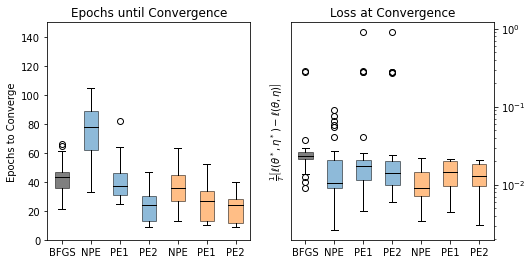

In [5]:
fig1, axs1 = plt.subplots(1,2,figsize = (8,4))

cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

keys = [("BFGS",0.0),("SAGA",0.0),("SAGA",0.5),("SAGA",1.0),("SVRG",0.0),("SVRG",0.5),("SVRG",1.0)]
labs = ["BFGS","NPE","PE1","PE2","NPE","PE1","PE2"]

data_to_plot = []
for key in keys:
    data_to_plot.append(epochs_to_converge[key])

box = axs1[0].boxplot(data_to_plot, 
                          whiskerprops=dict(color="black"),
                          medianprops=dict(color="black"),
                          patch_artist=True,
                          labels=labs)#['BFGS',0,0.5,1])

linestyles = {("BFGS",0.0):("black","-"),
              ("CG",0.0)  :("black","--"),
              ("GD",0.0)  :("black",":"),
              ("SAGA",0.0):(cmap(0),"-"),
              ("SAGA",0.5):(cmap(0),"--"),
              ("SAGA",1.0):(cmap(0),":"),
              ("SVRG",0.0):(cmap(1),"-"),
              ("SVRG",0.5):(cmap(1),"--"),
              ("SVRG",1.0):(cmap(1),":")}

for patch, key in zip(box['boxes'], keys):
    print(key)
    patch.set_facecolor(linestyles[key][0])
    patch.set_alpha(0.5)

axs1[0].set_ylabel("Epochs to Converge")
axs1[0].set_ylim([0,150])
axs1[0].set_title("Epochs until Convergence")

#######

data_to_plot = []
for key in keys:
    data_to_plot.append(ll_star - lls[key])

box = axs1[1].boxplot(data_to_plot, 
                       whiskerprops=dict(color="black"),
                       medianprops=dict(color="black"),
                       patch_artist=True,
                       labels=labs)#['BFGS',0,0.5,1])

linestyles = {("BFGS",0.0):("black","-"),
              ("CG",0.0)  :("black","--"),
              ("GD",0.0)  :("black",":"),
              ("SAGA",0.0):(cmap(0),"-"),
              ("SAGA",0.5):(cmap(0),"--"),
              ("SAGA",1.0):(cmap(0),":"),
              ("SVRG",0.0):(cmap(1),"-"),
              ("SVRG",0.5):(cmap(1),"--"),
              ("SVRG",1.0):(cmap(1),":")}

for patch, key in zip(box['boxes'], keys):
    patch.set_facecolor(linestyles[key][0])
    patch.set_alpha(0.5)

axs1[1].set_ylabel(r"$\frac{1}{T} \left[\ell(\theta^*, \eta^*) - \ell(\theta, \eta)\right]$")
axs1[1].set_yscale("log")
#axs2.set_ylim([1e-8,1e0])
axs1[1].set_title("Loss at Convergence")
axs1[1].yaxis.tick_right()


if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

fig1.savefig(plot_folder + '/boxplots_case_study.png',dpi=500)

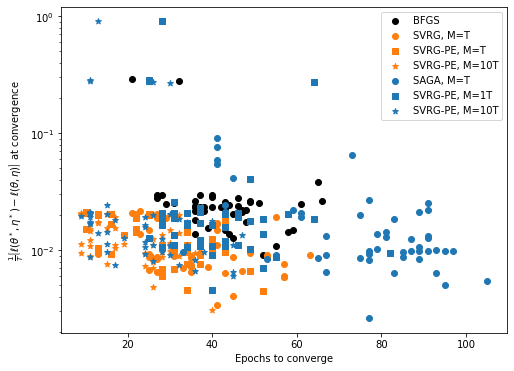

In [6]:
fig1, axs1 = plt.subplots(1,1,figsize = (8,6))

cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

keys = [("BFGS",0.0),("SVRG",0.0),("SVRG",0.5),("SVRG",1.0),("SAGA",0.0),("SAGA",0.5),("SAGA",1.0)]
labs = ["BFGS",0,0.5,1,0,0.5,1]

# define linestyles
pointstyles = {("BFGS",0.0):("black","o"),
               ("CG",0.0)  :("black","s"),
               ("GD",0.0)  :("black","*"),
               ("SVRG",0.0):(cmap(1),"o"),
               ("SVRG",0.5):(cmap(1),"s"),
               ("SVRG",1.0):(cmap(1),"*"),
               ("SAGA",0.0):(cmap(0),"o"),
               ("SAGA",0.5):(cmap(0),"s"),
               ("SAGA",1.0):(cmap(0),"*")}

legend_elem = {("BFGS",0.0): "BFGS",
               ("CG",0.0)  : "CG",
               ("GD",0.0)  : "GD",
               ("SVRG",0.0): "SVRG, M=T",
               ("SVRG",0.5): "SVRG-PE, M=T",
               ("SVRG",1.0): "SVRG-PE, M=10T",
               ("SAGA",0.0): "SAGA, M=T",
               ("SAGA",0.5): "SVRG-PE, M=1T",
               ("SAGA",1.0): "SVRG-PE, M=10T"}

# get data
epochs_to_plot = []
for key in keys:
    epochs_to_plot.append(epochs_to_converge[key])

lls_to_plot = []
for key in keys:
    lls_to_plot.append(ll_star - lls[key])

# plot data
for key,epoch_data,ll_data in zip(keys,epochs_to_plot,lls_to_plot):
    axs1.scatter(epoch_data,ll_data,
                 color = pointstyles[key][0],
                 marker = pointstyles[key][1])

# adjust axes
axs1.set_yscale('log')
axs1.set_ylabel(r"$\frac{1}{T} \left[\ell(\theta^*, \eta^*) - \ell(\theta, \eta)\right]$ at convergence")
axs1.set_xlabel("Epochs to converge")
axs1.legend([legend_elem[key] for key in keys])

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

fig1.savefig(plot_folder + '/scatterplot_case_study.png',dpi=500)

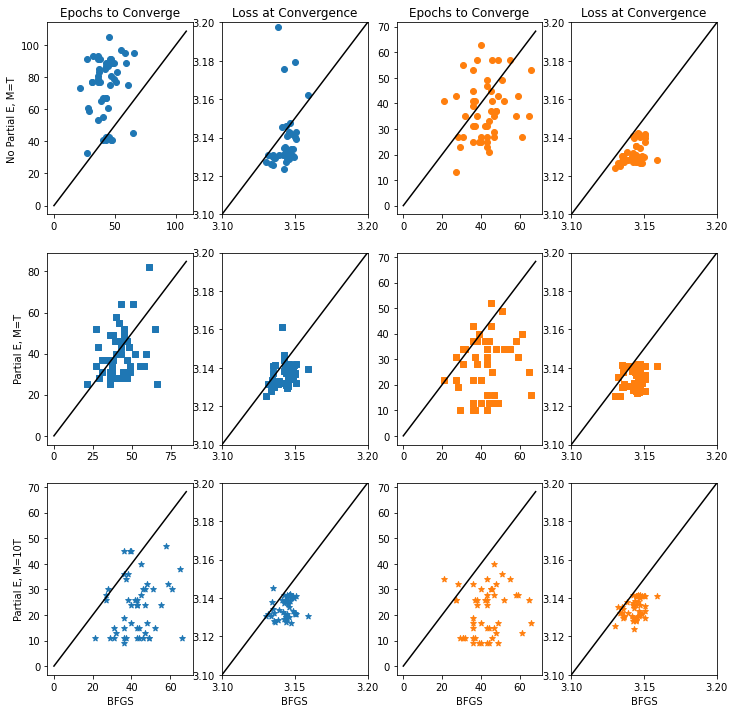

In [7]:
fig, axs = plt.subplots(3,4,figsize = (12,12))

ylabs = {("SAGA",0.0) : "No Partial E, M=T",
         ("SAGA",0.5) : "Partial E, M=T",
         ("SAGA",1.0) : "Partial E, M=10T",} 

for i,key in enumerate(keys):
    
    if key == ("BFGS",0.0):
        continue
    elif key[0] == "SAGA":
        yind = i-4
        xind = 0
    else:
        yind = i-1
        xind = 2
    
    axs[yind,xind].scatter(epochs_to_converge[('BFGS', 0.0)],
                           epochs_to_converge[key],
                           color = pointstyles[key][0],
                           marker = pointstyles[key][1])
    
    max_epochs = max(axs[yind,xind].get_xlim()[1],axs[yind,xind].get_ylim()[1])
    axs[yind,xind].plot([0,max_epochs],[0,max_epochs],'k')
    
    if yind == 0:
        axs[yind,xind].set_title("Epochs to Converge")
    if yind == 2:
        axs[yind,xind].set_xlabel("BFGS")
    if xind == 0:
        axs[yind,xind].set_ylabel(ylabs[key])
    
    axs[yind,xind+1].scatter([-x for x in lls[('BFGS', 0.0)]],
                             [-x for x in lls[key]],
                             color = pointstyles[key][0],
                             marker = pointstyles[key][1])
    
    axs[yind,xind+1].set_xlim([3.1,3.2])
    axs[yind,xind+1].set_ylim([3.1,3.2])
    
    max_epochs = max(axs[yind,xind+1].get_xlim()[1],axs[yind,xind+1].get_ylim()[1])
    min_epochs = min(axs[yind,xind+1].get_xlim()[0],axs[yind,xind+1].get_ylim()[0])
    axs[yind,xind+1].plot([min_epochs,max_epochs],[min_epochs,max_epochs],'k')
    
    if yind == 0:
        axs[yind,xind+1].set_title("Loss at Convergence")
    if yind == 2:
        axs[yind,xind+1].set_xlabel("BFGS")
        
fig.savefig(plot_folder + '/paired_scatterplot_case_study.png',dpi=500)

# Plot Results

In [8]:
def find_perm(optim,eta_star,theta_star):
    
    # get the coarse-scale permutation of states
    cost_matrix = np.zeros((optim.K[0],optim.K[0]))
    
    # get the coarse-scale permutation
    Gamma_coarse_star = np.exp(eta_2_log_Gamma(eta_star)[0])
    Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1])

    Gamma_coarse_optm = np.exp(eta_2_log_Gamma(optim.eta)[0])
    Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta)[1])

    # get the trace of each fine-scale ptm
    for k0_star in range(optim.K[0]):
        square_dists = np.zeros(optim.K[0])
        for k0_optm in range(optim.K[0]):
            square_dists[k0_optm] += (Gamma_coarse_star[k0_star,k0_star] - \
                                      Gamma_coarse_optm[k0_optm,k0_optm])**2 
            square_dists[k0_optm] += (np.trace(Gamma_fine_star[k0_star]) - \
                                      np.trace(Gamma_fine_optm[k0_optm]))**2 

        cost_matrix[k0_star] = square_dists

    star_states_coarse, optim_states_coarse = linear_sum_assignment(cost_matrix)

    # get the fine-scale permutations
    star_states_fine = [None for _ in range(optim.K[0])]
    optim_states_fine = [None for _ in range(optim.K[0])]

    for k0_star in range(optim.K[0]):
        k0_optm = optim_states_coarse[k0_star]

        # get the fine-scale permutation of states
        cost_matrix = np.zeros((optim.K[1],optim.K[1]))

        # get the fine-scale permutation
        Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1][k0_star])
        Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta)[1][k0_optm])

        for k1_star in range(optim.K[1]):
            square_dists = np.zeros(optim.K[1])
            for k1_optm in range(optim.K[1]):
                for feature in optim.features:
                    square_dists[k1_optm] += (theta_star[k0_star][feature]['mu'][k1_star] - \
                                              optim.theta[k0_optm][feature]['mu'][k1_optm])**2 
                    square_dists[k1_optm] += (np.exp(theta_star[k0_star][feature]['log_sig'][k1_star]) - \
                                              np.exp(optim.theta[k0_optm][feature]['log_sig'][k1_optm]))**2 
                square_dists[k1_optm] += (Gamma_fine_star[k1_star,k1_star] - \
                                          Gamma_fine_optm[k1_optm,k1_optm])**2 

            cost_matrix[k1_star] = square_dists

        star_states_fine[k0_star], optim_states_fine[k0_optm] = linear_sum_assignment(cost_matrix)

    return optim_states_coarse,optim_states_fine

In [9]:
def find_distances(optim,theta_star,eta_star,eta0_star):

    # get permutation
    optim_states_coarse,optim_states_fine = find_perm(optim,eta_star,theta_star)
    
    # now get distances
    square_dists = np.zeros(len(optim.epoch_trace))

    Gamma_coarse_star = np.exp(eta_2_log_Gamma(eta_star)[0])
    Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1])

    delta_coarse_star = np.exp(eta0_2_log_delta(eta0_star)[0])
    delta_fine_star = np.exp(eta0_2_log_delta(eta0_star)[1])

    for i in range(len(optim.epoch_trace)):

        # add theta
        for k0_star in range(optim.K[0]):
            k0_optm = optim_states_coarse[k0_star]
            for k1_star in range(optim.K[1]):
                k1_optm = optim_states_fine[k0_optm][k1_star]
                for feature in optim.features:
                    square_dists[i] += (theta_star[k0_star][feature]['mu'][k1_star] - \
                                        optim.theta_trace[i][k0_optm][feature]['mu'][k1_optm])**2 
                    square_dists[i] += (np.exp(theta_star[k0_star][feature]['log_sig'][k1_star]) - \
                                        np.exp(optim.theta_trace[i][k0_optm][feature]['log_sig'][k1_optm]))**2 

        
        # get Gamma and delta
        Gamma_coarse_optm = np.exp(eta_2_log_Gamma(optim.eta_trace[i])[0])
        Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta_trace[i])[1])

        delta_coarse_optm = np.exp(eta0_2_log_delta(optim.eta0_trace[i])[0])
        delta_fine_optm = np.exp(eta0_2_log_delta(optim.eta0_trace[i])[1])

        # add coarse Gamma and delta
        for i_star in range(optim.K[0]):
            i_optm = optim_states_coarse[i_star]

            for j_star in range(optim.K[0]):
                j_optm = optim_states_coarse[j_star]

                square_dists[i] += (Gamma_coarse_star[i_star,j_star] - \
                                    Gamma_coarse_optm[i_optm,j_optm])**2

            # BUG IN CODE NEED TO FIX :(
            #square_dists[i] += (delta_coarse_star[i_star] - \
            #                    delta_coarse_optm[i_optm])**2
            

        # add fine Gamma and delta
        for k0_star in range(optim.K[0]):
            k0_optm = optim_states_coarse[k0_star]

            for i_star in range(optim.K[1]):
                i_optm = optim_states_fine[k0_optm][i_star]

                for j_star in range(optim.K[1]):
                    j_optm = optim_states_fine[k0_optm][j_star]

                    square_dists[i] += (Gamma_fine_star[k0_star][i_star,j_star] - \
                                        Gamma_fine_optm[k0_optm][i_optm,j_optm])**2

                # BUG IN CODE NEED TO FIX :(
                #square_dists[i] += (delta_fine_star[k0_star][i_star] - \
                #delta_fine_optm[k0_optm][i_optm])**2
                
    return square_dists

In [10]:
def plot_dists(optims,theta_star,eta_star,eta0_star,x_time=False,xlims=None,ylims=None):
    
    legend = []
    plt.figure(figsize=(8,6))
    
    for method in methods:
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                lcol = linestyles[(method,partial_E)][0]
                ltyp = linestyles[(method,partial_E)][1]
                
                dists = find_distances(optim,theta_star,eta_star,eta0_star)
                
                if x_time:
                    plt.plot(optim.time_trace,dists,
                             color=lcol,linestyle=ltyp)
                else:
                    plt.plot(optim.epoch_trace,dists,
                             color=lcol,linestyle=ltyp)   
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$||(\theta^*, \eta^*) - (\theta, \eta)||^2_2$")
    plt.yscale("log")
    plt.legend(legend,loc='upper center', bbox_to_anchor=(0.5, 1.2),
               ncol=3)
    #plt.legend(legend)
    
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig(plot_folder + "/dist_v_time_K-%d-%d.png"%(K[0],K[1]),dpi=500)
    else:
        plt.xlabel("Epoch")
        plt.savefig(plot_folder + "/dist_v_epoch_K-%d-%d.png"%(K[0],K[1]),dpi=500)
        
    if not xlims is None:
        plt.xlim(xlims)
    if not ylims is None:
        plt.ylim(ylims)
        
    plt.show()
                
    return

In [11]:
def plot_results(optim,ll_star,method,partial_E,M,features,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    else:
        title += ", no partial E"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    x = optim.epoch_trace
    
    # plot log of gradient of log-likelihood
    plt.plot(optim.epoch_trace,np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig(plot_folder + "/grad-hat-ll-%s-%s-K-%d-%d.png"%(method,partial_E,K[0],K[1]),dpi=300)
    plt.show()
    
    for feature in features:
        
        # plot means
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][k0][feature]['mu'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\mu^{(%d,%d)}$"%(k0+1,k1+1))

        plt.title(feature + r" $\mu$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig(plot_folder + "/mu-%s-%s-%d-K-%d-%d.png"%(method,partial_E,M,K[0],K[1]),dpi=500)
        plt.show()

        # plot log(sigma)
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][k0][feature]['log_sig'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\log\left(\sigma^{(%d,%d)}\right)$"%(k0+1,k1+1))

        plt.title(feature + r" $\log\left(\sigma\right)$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig(plot_folder + "/log-sig-%s-%s-%d-K-%d-%d.png"%(method,partial_E,M,K[0],K[1]),dpi=500)
        plt.show()
    
    # plot eta_coarse
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig(plot_folder + "/eta-%s-%s-%d-K-%d-%d.png"%(method,partial_E,M,K[0],K[1]),dpi=500)
    plt.show()
    
    # plot eta_fine
    legend = []
    for k0 in range(optim.K[0]):
        for i in range(optim.K[1]):
            for j in range(optim.K[1]):
                if i != j:
                    plt.plot(x,[optim.eta_trace[t][1][k0][i,j] for t in range(len(optim.eta_trace))])
                    legend.append(r"$\eta_%d^{*(%d,%d)}$" % (k0,i+1,j+1))
    plt.title(r"$\eta^*$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig(plot_folder + "/eta-fine-%s-%s-%d-K-%d-%d.png"%(method,partial_E,M,K[0],K[1]),dpi=500)
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()

In [66]:
def plot_ll(optims,x_time=False,xlims=None,ylims=None):
    
    legend = []
    plt.figure(figsize=(8,6))
    
    # make lines
    for method in methods:
        for partial_E in [0,0.5,1]:
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                ltyp = linestyles[(method,partial_E)][1]
                
                eind = min(np.where(np.array(optim.epoch_trace) >= 150)[0],
                           default=len(optim.grad_norm_trace))
                
                if x_time:
                    plt.plot(optim.time_trace[:eind],
                             ll_star-optim.log_like_trace[:eind],
                             color=linestyles[(method,partial_E)][0],
                             linestyle=linestyles[(method,partial_E)][1])
                else:
                    plt.plot(optim.epoch_trace[:eind],
                             ll_star-optim.log_like_trace[:eind],
                             color=linestyles[(method,partial_E)][0],
                             linestyle=linestyles[(method,partial_E)][1])
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
         
        
    plt.ylabel(r"$\frac{1}{T} \left[\ell(\theta^*, \eta^*) - \ell(\theta, \eta)\right]$")
    plt.yscale("log")
    plt.legend(legend,loc='upper center', 
               bbox_to_anchor=(0.5, 1.17),
               ncol=3)
    
    # add points          
    for method in methods:
        for partial_E in [0,0.5,1]:
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            if (method,partial_E) in optims:
                optim = optims[(method,partial_E)]
                eind = min(np.where(np.array(optim.epoch_trace) >= 150)[0],
                           default=len(optim.grad_norm_trace))
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                
                if converge_ind >= eind-1:
                    continue
                    
                if x_time:
                    plt.plot(optim.time_trace[converge_ind],
                             ll_star-optim.log_like_trace[converge_ind],
                             color = pointstyles[(method,partial_E)][0],
                             marker = pointstyles[(method,partial_E)][1])
                else:
                    plt.plot(optim.epoch_trace[converge_ind],
                             ll_star-optim.log_like_trace[converge_ind],
                             color = pointstyles[(method,partial_E)][0],
                             marker = pointstyles[(method,partial_E)][1])
    
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig(plot_folder + "/log-like_v_time_K-%d-%d.png"%(K[0],K[1]),dpi=500)
    else:
        plt.xlabel("Epoch")
        plt.savefig(plot_folder + "/log-like_v_epoch_K-%d-%d.png"%(K[0],K[1]),dpi=500)
        
    if not xlims is None:
        plt.xlim(xlims)
    if not ylims is None:
        plt.ylim(ylims)
        
    plt.show()
                
    return

In [67]:
if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

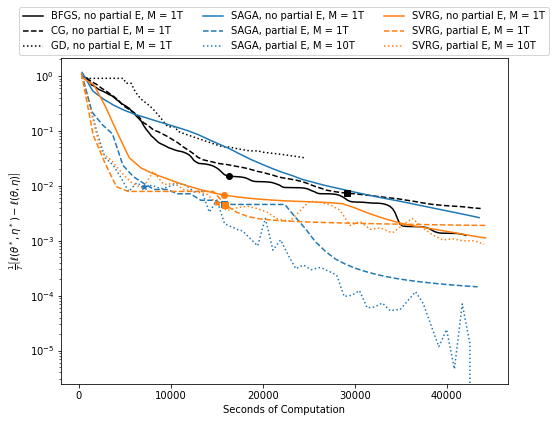

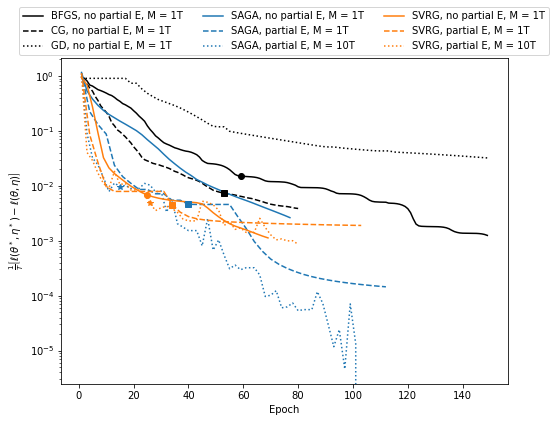

In [68]:
plot_ll(optims,x_time=True)#,xlims=[0,600],ylims=[1e-2,1e1])
plot_ll(optims,x_time=False)#,xlims=[0,10],ylims=[1e-2,1e1])

In [72]:
for key in keys:
    print(key)
    print(optims[key].grad_norm_trace[-1])
    print("")

('BFGS', 0.0)
0.0008610039750080391

('SVRG', 0.0)
0.002244164790830559

('SVRG', 0.5)
8.978662306209768e-05

('SVRG', 1.0)
0.0022254510541702783

('SAGA', 0.0)
0.011170223891685774

('SAGA', 0.5)
0.0005827559085320443

('SAGA', 1.0)
0.0006096159271164292



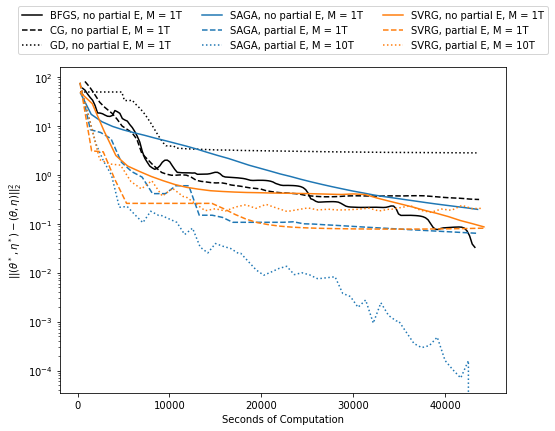

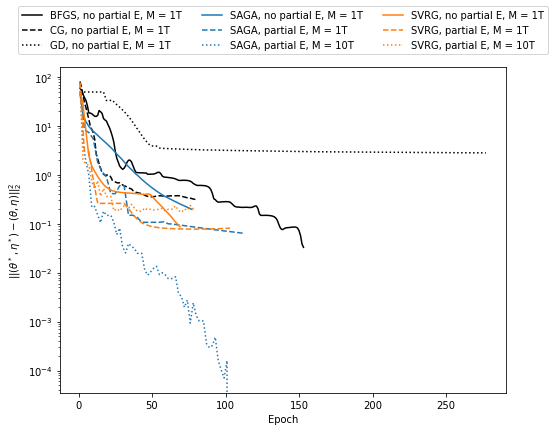

In [73]:
plot_dists(optims,theta_star,eta_star,eta0_star,x_time=True)
plot_dists(optims,theta_star,eta_star,eta0_star,x_time=False)

In [ ]:
for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
    for partial_E in [0,0.5,1]:
        PE = (partial_E == 0.5) or (partial_E == 1)
        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
        if (method,partial_E) in optims:
            plot_results(optims[(method,partial_E)],
                         ll_star,method,PE,M,optims[("control",0.0)].features)